# **Predicting Dementia**
 
 Data from https://www.kaggle.com/jboysen/mri-and-alzheimers:

### **MRI and Alzheimers**
***Magnetic Resonance Imaging Comparisons of Demented and Nondemented Adults***

**The file contains Longitudinal MRI Data in Nondemented and Demented Older Adults:** longitudinal collection of 150 subjects aged 60 to 96. Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 72 of the subjects were characterized as nondemented throughout the study. 64 of the included subjects were characterized as demented at the time of their initial visits and remained so for subsequent scans, including 51 individuals with mild to moderate Alzheimer’s disease. Another 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit.

### **Dementia and Alzheimer:**



*   **Dementia** is an overall term that covers a wide range of specific medical conditions, including Alzheimer’s disease. 
Disorders grouped under the general term “dementia” are caused by abnormal brain changes. These changes trigger a decline in thinking skills, also known as cognitive abilities, severe enough to impair daily life and independent function. They also affect behavior, feelings and relationships.

*   **Alzheimer's disease** accounts for 60-80% of cases. Vascular dementia, which occurs because of microscopic bleeding and blood vessel blockage in the brain, is the second most common cause of dementia.

  © 2020 Alzheimer's Association®




In [672]:
# General tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

#Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

# For transformations and predictions

from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


%matplotlib inline

### **The Data:**

In [673]:
data = pd.read_csv('oasis_longitudinal.csv', index_col='MRI ID')
data.head()

,Subject ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
MRI ID,,,,,,,,,,,,,,
OAS2_0001_MR1,OAS2_0001,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
OAS2_0001_MR2,OAS2_0001,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
OAS2_0002_MR1,OAS2_0002,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
OAS2_0002_MR2,OAS2_0002,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
OAS2_0002_MR3,OAS2_0002,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [674]:
data.shape

(373, 14)

The dataset includes observations of:

*   MRI ID - MRI Exam Identification
*   Subject ID - Subject identification

*   Group - The class of dementia (Demented/ Nondemented/ Converted)
*   Visit - no. of visit 

*   MR Delay - MR Delay Time (Contrast)
*   M/F

*   Hand 
*   Age

*   EDUC - Years of Education
*   SES - Socioeconomic Status, assessed by the Hollingshead Index of Social Position and classified into categories from 1 (highest status) to 5 (lowest status)

*   MMSE - Mini Mental State Examination
*   CDR - Clinical Dementia Rating

*   eTIV - Estimated total intracranial volume
*   nWBV - Normalize Whole Brain Volume

*   ASF - Atlas Scaling Factor


In [675]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, OAS2_0001_MR1 to OAS2_0186_MR3
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   Group       373 non-null    object 
 2   Visit       373 non-null    int64  
 3   MR Delay    373 non-null    int64  
 4   M/F         373 non-null    object 
 5   Hand        373 non-null    object 
 6   Age         373 non-null    int64  
 7   EDUC        373 non-null    int64  
 8   SES         354 non-null    float64
 9   MMSE        371 non-null    float64
 10  CDR         373 non-null    float64
 11  eTIV        373 non-null    int64  
 12  nWBV        373 non-null    float64
 13  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(4)
memory usage: 43.7+ KB


In [676]:
data.nunique()

Subject ID    150
Group           3
Visit           5
MR Delay      201
M/F             2
Hand            1
Age            39
EDUC           12
SES             5
MMSE           18
CDR             4
eTIV          286
nWBV          136
ASF           265
dtype: int64

**The Target we choose: Clinical Dementia Rating (CDR) Scale**

A 5-point scale used to characterize six domains of cognitive and functional performance applicable to Alzheimer disease and related dementias: Memory, Orientation, Judgment & Problem Solving, Community Affairs, Home & Hobbies, and Personal Care. The necessary information to make each rating is obtained through a semi-structured interview of the patient and a reliable informant or collateral source (e.g., family member).

This score is useful for characterizing and tracking a patient's level of impairment/dementia:

0 = Normal

0.5 = Very Mild Dementia

1 = Mild Dementia

2 = Moderate Dementia

3 = Severe Dementia

www.adrc.wustl.edu

## **Pre-Processing:**

**Missing Values:**

In [677]:
#MMSE missing values:
data[data['MMSE'].isnull()]

,Subject ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
MRI ID,,,,,,,,,,,,,,
OAS2_0181_MR2,OAS2_0181,Demented,2,539,F,R,75,12,NaN,NaN,1.0,1169,0.742,1.501
OAS2_0181_MR3,OAS2_0181,Demented,3,1107,F,R,77,12,NaN,NaN,1.0,1159,0.733,1.515


We found that the missing values in MMSE feature refer to the same person.
We looked for her other visits:

In [678]:
data[data['Subject ID'] == data[data['MMSE'].isnull()]['Subject ID'][0]]

,Subject ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
MRI ID,,,,,,,,,,,,,,
OAS2_0181_MR1,OAS2_0181,Demented,1,0,F,R,74,12,NaN,26.0,0.5,1171,0.733,1.499
OAS2_0181_MR2,OAS2_0181,Demented,2,539,F,R,75,12,NaN,NaN,1.0,1169,0.742,1.501
OAS2_0181_MR3,OAS2_0181,Demented,3,1107,F,R,77,12,NaN,NaN,1.0,1159,0.733,1.515


Since she had just the first score of MMSE and this value can change for the other visits, we decided to see the distribution of this feature between the groups:

In [679]:
# Using for loop to remove each id with missing MMSE:
#for id in list_id_missing:
  #data=data[data['Subject ID'].ne(id)] # Using not equal method
#print(data.head())
# In case of new data, mind the number of subjects with missing values:
#print ('Please note, number of subjects removed: {}'. format(len(list_id_missing)))

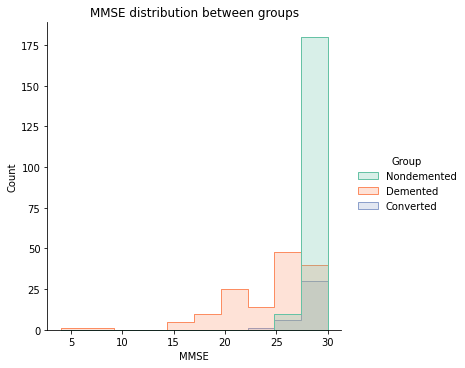

In [680]:
sns.displot(data, x='MMSE', hue="Group" ,bins=10, element="step", palette="Set2")
plt.title('MMSE distribution between groups')
plt.show()

We can see different distribution for this feature for the different groups, thus we will impute the missing values using the median of the 'Demented' group:

In [681]:
median_demented=data.where(data['Group']=='Demented').median()
median_demented

Visit          2.0000
MR Delay     490.5000
Age           76.0000
EDUC          13.0000
SES            3.0000
MMSE          26.0000
CDR            0.5000
eTIV        1476.5000
nWBV           0.7120
ASF            1.1885
dtype: float64

In [682]:
#Impute MMSE with median_demented
data['MMSE'].fillna(median_demented['MMSE'], inplace=True)
data[data['Subject ID']=='OAS2_0181']

,Subject ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
MRI ID,,,,,,,,,,,,,,
OAS2_0181_MR1,OAS2_0181,Demented,1,0,F,R,74,12,NaN,26.0,0.5,1171,0.733,1.499
OAS2_0181_MR2,OAS2_0181,Demented,2,539,F,R,75,12,NaN,26.0,1.0,1169,0.742,1.501
OAS2_0181_MR3,OAS2_0181,Demented,3,1107,F,R,77,12,NaN,26.0,1.0,1159,0.733,1.515


We also wanted to solve missing values in the SES feature. Let's look on the missing data:

In [683]:
##SES missing values:
missing_ses = data[data['SES'].isnull()]
missing_ses

,Subject ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
MRI ID,,,,,,,,,,,,,,
OAS2_0002_MR1,OAS2_0002,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
OAS2_0002_MR2,OAS2_0002,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
OAS2_0002_MR3,OAS2_0002,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
OAS2_0007_MR1,OAS2_0007,Demented,1,0,M,R,71,16,NaN,28.0,0.5,1357,0.748,1.293
OAS2_0007_MR3,OAS2_0007,Demented,3,518,M,R,73,16,NaN,27.0,1.0,1365,0.727,1.286
OAS2_0007_MR4,OAS2_0007,Demented,4,1281,M,R,75,16,NaN,27.0,1.0,1372,0.710,1.279
OAS2_0063_MR1,OAS2_0063,Demented,1,0,F,R,80,12,NaN,30.0,0.5,1430,0.737,1.228
OAS2_0063_MR2,OAS2_0063,Demented,2,490,F,R,81,12,NaN,27.0,0.5,1453,0.721,1.208
OAS2_0099_MR1,OAS2_0099,Demented,1,0,F,R,80,12,NaN,27.0,0.5,1475,0.762,1.190


In [684]:
# To know how many rows have missing SES:
missing_ses.shape

(19, 14)

We can see they all belong to the "Demented" group, but all the other variables are not consistence.  Moreover, these subjects have missing value of SES also in the visit 1, thus we cannot use it to evaluate the missing values.

We wanted to see the relation between SES categories to group:

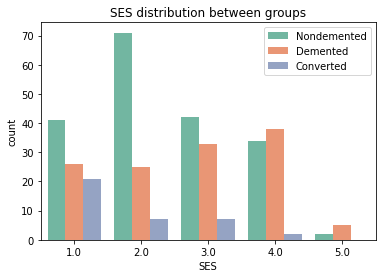

In [685]:
#sns.displot(data, x='SES', hue="Group" ,bins=10, element="step")
a= sns.countplot(x="SES",hue="Group", data=data, palette="Set2")
a.legend(loc=1)
plt.title('SES distribution between groups')
plt.show()

As one could see, no obvious pattern was found. 

Since SES may depends on various varliables (e.g.- education level, gender etc.)- taking the median will probably won't be accurate. Thus we apllied a KNN-imputer, so each subject would get the closest value, according to his neighbors. 

In [686]:
#Impute SES with KNN 
imputer = KNNImputer(n_neighbors=4, copy=False)
data['SES'] = imputer.fit_transform(X=data[['SES']], y=data['SES'])
data['SES'] = np.rint(data[['SES']])

Let's check the results:

In [687]:
data.loc[missing_ses.index]

,Subject ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
MRI ID,,,,,,,,,,,,,,
OAS2_0002_MR1,OAS2_0002,Demented,1,0,M,R,75,12,2.0,23.0,0.5,1678,0.736,1.046
OAS2_0002_MR2,OAS2_0002,Demented,2,560,M,R,76,12,2.0,28.0,0.5,1738,0.713,1.010
OAS2_0002_MR3,OAS2_0002,Demented,3,1895,M,R,80,12,2.0,22.0,0.5,1698,0.701,1.034
OAS2_0007_MR1,OAS2_0007,Demented,1,0,M,R,71,16,2.0,28.0,0.5,1357,0.748,1.293
OAS2_0007_MR3,OAS2_0007,Demented,3,518,M,R,73,16,2.0,27.0,1.0,1365,0.727,1.286
OAS2_0007_MR4,OAS2_0007,Demented,4,1281,M,R,75,16,2.0,27.0,1.0,1372,0.710,1.279
OAS2_0063_MR1,OAS2_0063,Demented,1,0,F,R,80,12,2.0,30.0,0.5,1430,0.737,1.228
OAS2_0063_MR2,OAS2_0063,Demented,2,490,F,R,81,12,2.0,27.0,0.5,1453,0.721,1.208
OAS2_0099_MR1,OAS2_0099,Demented,1,0,F,R,80,12,2.0,27.0,0.5,1475,0.762,1.190


**Dropping Features:**

We will drop now the 'Hand' column, since all subjects are right handed

In [688]:
# Dropping hand column, as all of thesubjects are right-handed:
data.drop('Hand',axis=1,inplace=True)
data.head()

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
MRI ID,,,,,,,,,,,,,
OAS2_0001_MR1,OAS2_0001,Nondemented,1,0,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
OAS2_0001_MR2,OAS2_0001,Nondemented,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
OAS2_0002_MR1,OAS2_0002,Demented,1,0,M,75,12,2.0,23.0,0.5,1678,0.736,1.046
OAS2_0002_MR2,OAS2_0002,Demented,2,560,M,76,12,2.0,28.0,0.5,1738,0.713,1.010
OAS2_0002_MR3,OAS2_0002,Demented,3,1895,M,80,12,2.0,22.0,0.5,1698,0.701,1.034


# **EDA**

**CDR:**

In [689]:
data['CDR'].value_counts()

0.0    206
0.5    123
1.0     41
2.0      3
Name: CDR, dtype: int64

We can see we are dealing with unbalanced data- with many observations for class "0" and "0.5", but only few in "1" and "2". 

In [690]:
#Changing CDR variable to category:
data['CDR'] = data['CDR'].astype('category', copy=False)

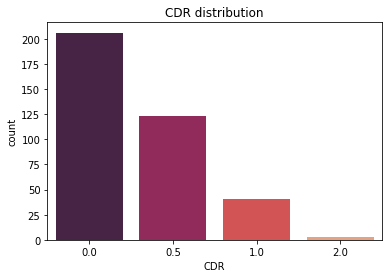

In [691]:
sns.countplot(x='CDR', data=data, palette="rocket")
plt.title('CDR distribution')
plt.show()

We define the CDR target as Categorial featue.
The CDR distribution is imbalanced, thus we will handle it before modeling.

In [692]:
#CDR = 2 is unbalanced and we will refer to it in the models

**Group:**

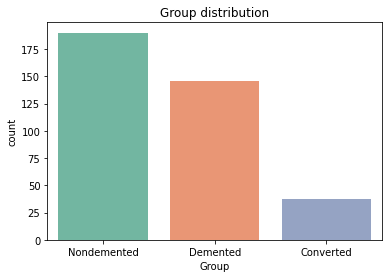

In [693]:
#Groups:
sns.countplot(x='Group', data=data, palette="Set2")
plt.title('Group distribution')
plt.show()


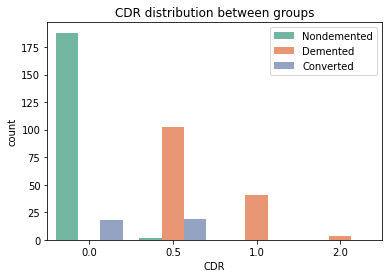

In [694]:
a=sns.countplot(x='CDR',hue='Group', data=data, palette="Set2")
plt.title('CDR distribution between groups')
a.legend(loc=1)
plt.show()

**Gender:**

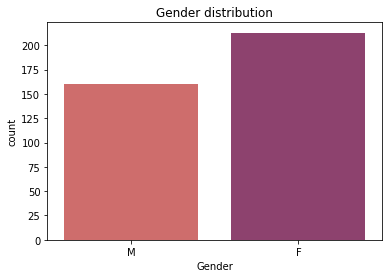

In [695]:
#M/F:
sns.countplot(x='M/F', data=data, palette="flare")
plt.title('Gender distribution')
plt.xlabel("Gender")
plt.show()

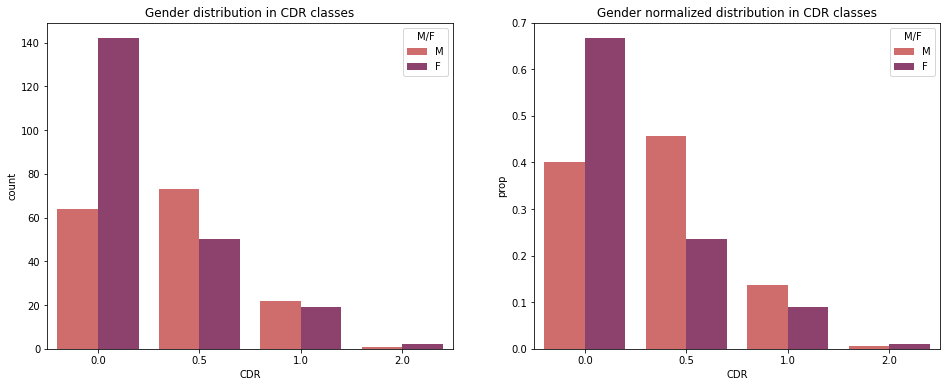

In [696]:
f, axes = plt.subplots(1,2, figsize=(16,6))
sns.countplot(x="CDR", hue='M/F' ,data=data, ax=axes[0], palette="flare")
axes[0].set_title('Gender distribution in CDR classes')
df = data['CDR'].groupby(data['M/F']).value_counts(normalize=True, ascending=True).rename('prop').reset_index().sort_values(by='M/F', ascending=False)
sns.barplot(x='CDR', y= 'prop', hue='M/F' ,data=df ,ax=axes[1], palette="flare")
axes[1].set_title('Gender normalized distribution in CDR classes')
plt.show()

**Age:**

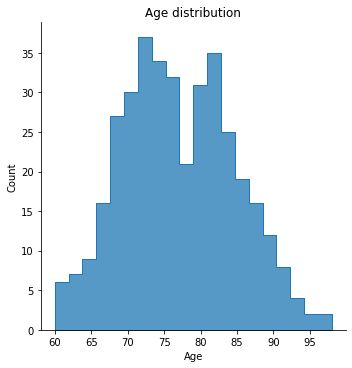

In [697]:
#Age:
#Distribution
sns.displot(data['Age'], bins=20, element="step", )
plt.title('Age distribution')
plt.show()

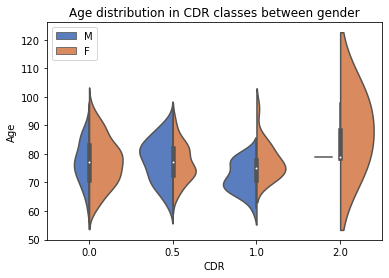

In [698]:
#Age vs. CDR (devided by gender):
a= sns.violinplot(x="CDR", y="Age", hue="M/F",
                    data=data, palette="muted", split=True, scale="count")
a.legend(loc=2)
plt.title('Age distribution in CDR classes between gender')
plt.show()

**Socioeconomic and Educational Status:**

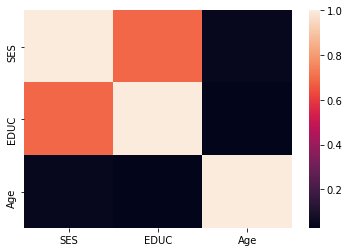

In [699]:
#SES corr:
sns.heatmap(data[['SES', 'EDUC', 'Age']].corr().abs())
plt.show()

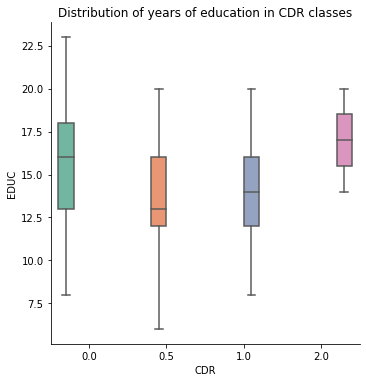

In [700]:
sns.catplot(x='CDR', y='EDUC', hue='CDR', kind='box', data=data, palette="Set2")
plt.title('Distribution of years of education in CDR classes')
plt.show()

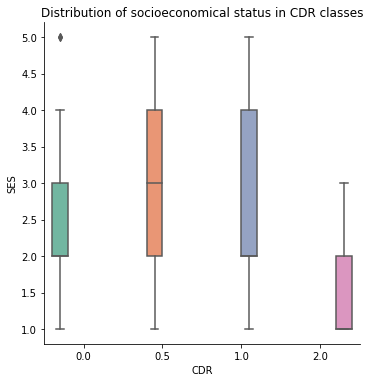

In [701]:
sns.catplot(x='CDR', y='SES', hue='CDR', kind='box', data=data, palette="Set2")
plt.title('Distribution of socioeconomical status in CDR classes')
plt.show()


**MMSE:**

The Mini–Mental State Examination (MMSE) or Folstein test is a 30-point questionnaire.

Any score of 24 or more (out of 30) indicates a normal cognition. Below this, scores can indicate severe (≤9 points), moderate (10–18 points) or mild (19–23 points) cognitive impairment. The raw score may also need to be corrected for educational attainment and age.

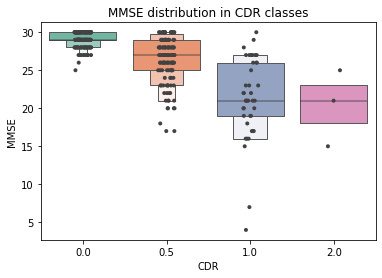

In [702]:
ax = sns.boxenplot(x="CDR", y="MMSE", data=data,
                   showfliers=False, palette="Set2")
ax = sns.stripplot(x="CDR", y="MMSE", data=data,
                   size=4, color=".26")
plt.title('MMSE distribution in CDR classes')
plt.show()

In [703]:
# Checking subjects with MMSE score lower than 10:
data[data['MMSE'] < 10]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
MRI ID,,,,,,,,,,,,,
OAS2_0048_MR4,OAS2_0048,Demented,4,970,M,68,16,1.0,7.0,1.0,1714,0.682,1.024
OAS2_0048_MR5,OAS2_0048,Demented,5,1233,M,69,16,1.0,4.0,1.0,1701,0.676,1.032


In [704]:
data[data['Subject ID'] == data[data['MMSE']<10]['Subject ID'][0]]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
MRI ID,,,,,,,,,,,,,
OAS2_0048_MR1,OAS2_0048,Demented,1,0,M,66,16,1.0,19.0,1.0,1695,0.711,1.036
OAS2_0048_MR2,OAS2_0048,Demented,2,248,M,66,16,1.0,21.0,1.0,1708,0.703,1.028
OAS2_0048_MR3,OAS2_0048,Demented,3,647,M,68,16,1.0,19.0,1.0,1712,0.691,1.025
OAS2_0048_MR4,OAS2_0048,Demented,4,970,M,68,16,1.0,7.0,1.0,1714,0.682,1.024
OAS2_0048_MR5,OAS2_0048,Demented,5,1233,M,69,16,1.0,4.0,1.0,1701,0.676,1.032


There are 2 observations with 'MMSE' < 9. The two of them belong to the same person, which had a score of mild cognitive impairment in his 3 former visits. However, other features (e.g. MRI variables, CDR, etc.) does not support such decline in the MMSE scoring. Thus, we decided to drop this subject, as he has exceptional low MMSE score.

In [705]:
data.drop(data[data['MMSE'] < 10].index, axis=0, inplace=True)

**MRI Attributes:**

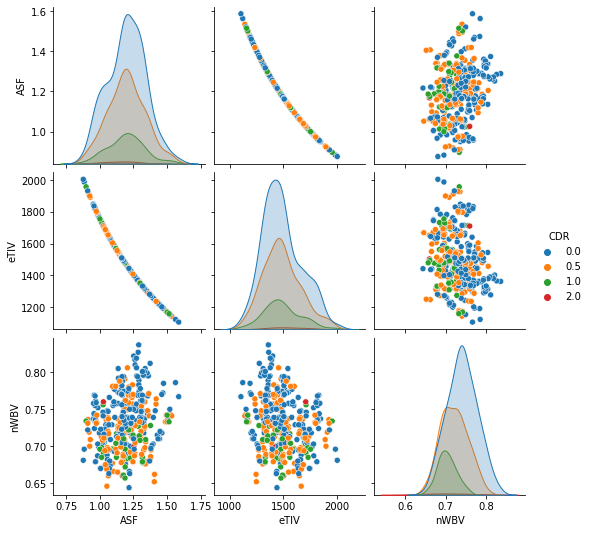

In [706]:
#MRI attributes:
sns.pairplot(data=data[['ASF', 'eTIV', 'nWBV', 'CDR']], hue='CDR')
plt.show()

In [707]:
data[['ASF', 'eTIV']].corr()

,ASF,eTIV
ASF,1.000000,-0.988788
eTIV,-0.988788,1.000000


As can be seen both in the graph above and the correlation matrix- AST and eTIV are strongly correlated. Using both of them may cause multicolinearity. Hance,  we will use just 'ASF' attribute (dropping eTIV in the dropping section).

**Dummies Varibles:**

In [708]:
#Gender:
gender_map = {'F':0, 'M':1}
data['M/F'] = data['M/F'].map(gender_map)

#Group
group_map = {'Nondemented':0, 'Converted':1, 'Demented':2}
data['Group'] = data['Group'].map(group_map)

#SES:
data['SES'] = data['SES'].astype('category', copy=False)

#CDR
cdr_map = {0.0: 0, 0.5:1, 1.0:2, 2.0:3}
data['CDR'] = data['CDR'].map(cdr_map)

Please Note- We re-coded CDR just in order form the variable into category type (new values are : 0,1,2 and 3). However, we will still refer the old values (i.e 0, 0.5, 1 and 2), to avoid confusion.

## **Getting started...**


In [709]:
data_v2= data.copy(deep=True)

In [710]:
# Dropping Features:
# Retrospective Note- in version 1, the group feature received high importance, but since our scores 
# were low, we thought removing it shpuld improve the results (we will use this feature in version2). 
data.drop(['eTIV', 'MR Delay', 'Visit', 'Subject ID', 'Group'],axis=1,inplace=True)
data.head()

,M/F,Age,EDUC,SES,MMSE,CDR,nWBV,ASF
MRI ID,,,,,,,,
OAS2_0001_MR1,1,87,14,2.0,27.0,0,0.696,0.883
OAS2_0001_MR2,1,88,14,2.0,30.0,0,0.681,0.876
OAS2_0002_MR1,1,75,12,2.0,23.0,1,0.736,1.046
OAS2_0002_MR2,1,76,12,2.0,28.0,1,0.713,1.010
OAS2_0002_MR3,1,80,12,2.0,22.0,1,0.701,1.034


**Splitting The Data:**

In [711]:
#Splitting:
X = data.drop('CDR', axis=1)
y = data.CDR

X_train, X_test, y_train, y_test = split(X, y, train_size=0.8, 
                                                    test_size=0.2, random_state=12345)

In [712]:
X_train.head()

,M/F,Age,EDUC,SES,MMSE,nWBV,ASF
MRI ID,,,,,,,
OAS2_0142_MR2,0,71,16,3.0,28.0,0.810,1.262
OAS2_0049_MR2,0,70,16,3.0,30.0,0.791,1.166
OAS2_0143_MR2,0,91,18,2.0,30.0,0.741,1.024
OAS2_0129_MR3,0,82,18,1.0,29.0,0.644,1.217
OAS2_0095_MR2,1,72,18,1.0,29.0,0.687,0.983


**Scaling:**

In [713]:
#scaling the data
my_scaler = StandardScaler().fit(X_train)

X_train_scaled = pd.DataFrame(my_scaler.transform(X_train), index=X_train.index ,columns=X_train.columns)
X_test_scaled = pd.DataFrame(my_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

X_train_scaled.head()

#data.describe()

,M/F,Age,EDUC,SES,MMSE,nWBV,ASF
MRI ID,,,,,,,
OAS2_0142_MR2,-0.831522,-0.908535,0.484464,0.552388,0.154357,2.305592,0.448914
OAS2_0049_MR2,-0.831522,-1.046163,0.484464,0.552388,0.775987,1.763644,-0.238352
OAS2_0143_MR2,-0.831522,1.844037,1.185694,-0.361058,0.775987,0.337465,-1.254934
OAS2_0129_MR3,-0.831522,0.605380,1.185694,-1.274503,0.465172,-2.429322,0.126758
OAS2_0095_MR2,1.202614,-0.770906,1.185694,-1.274503,0.465172,-1.202809,-1.548454


# **Modeling:**
We will present two version:

1- With CDR from all classes.

2- Without CDR=2, since it has only 3 observartions.

In [714]:
#func for report (accuracy, classification report, log loss)
def report(clf, X, y):
    acc = accuracy_score(y_true=y, 
                         y_pred=clf.predict(X))
    cm = pd.DataFrame(confusion_matrix(y_true=y, 
                                       y_pred=clf.predict(X)), 
                      index=clf.classes_, 
                      columns=clf.classes_)
    rep = classification_report(y_true=y, 
                                y_pred=clf.predict(X))
    ll = log_loss(y, pd.DataFrame(clf.predict_proba(X), 
                            columns=clf.classes_))
    rocauc = roc_auc_score(y, pd.DataFrame(clf.predict_proba(X), 
                        columns=clf.classes_), multi_class='ovo')
    return 'cm: \n{}\n\n{}\n\n accuracy: {:.3f}\n\nlog_loss: {:.3f}\n\nroc_auc_score: {:.3f} '.format(cm, rep,acc,  ll, rocauc)
    #return 'accuracy: {:.3f}\n\n{}\n\n{}\n\n log_loss: {}'.format(acc, cm, rep, ll)


# **Version #1:**

## **Decision Tree Model:**

With CDR from all classes. We cannot over-sampling the data due to very low proportion of 'CDR' from class 2.

We will use penalty method during the models.

Baseline Model:

In [715]:
#Desicion Tree Model:
dt_model_1 = DecisionTreeClassifier(max_depth=5, class_weight= 'balanced', random_state=12345)
dt_model_1.fit(X_train_scaled, y_train)
pd.Series(dt_model_1.feature_importances_,index=X_train_scaled.columns)
y_train_pred = pd.DataFrame(dt_model_1.predict_proba(X_train_scaled), 
                            columns=dt_model_1.classes_)

In [716]:
dt_model_1.feature_importances_

array([0.016043  , 0.37976197, 0.110258  , 0.        , 0.37435854,
       0.06677468, 0.0528038 ])

In [717]:
#report for train data:
print(report(dt_model_1, X_train_scaled, y_train))

cm: 
     0   1   2  3
0  138  26   3  0
1   12  74  13  0
2    0   0  28  0
3    0   0   0  2

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       167
           1       0.74      0.75      0.74        99
           2       0.64      1.00      0.78        28
           3       1.00      1.00      1.00         2

    accuracy                           0.82       296
   macro avg       0.82      0.89      0.85       296
weighted avg       0.83      0.82      0.82       296


 accuracy: 0.818

log_loss: 0.372

roc_auc_score: 0.981 


In [718]:
#validation of test data:
y_test_pred = pd.DataFrame(dt_model_1.predict_proba(X_test_scaled), 
                        columns=dt_model_1.classes_)

In [719]:
#report for test data:
print(report(dt_model_1, X_test_scaled, y_test))

cm: 
    0  1  2  3
0  33  5  1  0
1   8  9  7  0
2   1  3  7  0
3   0  0  1  0

              precision    recall  f1-score   support

           0       0.79      0.85      0.81        39
           1       0.53      0.38      0.44        24
           2       0.44      0.64      0.52        11
           3       0.00      0.00      0.00         1

    accuracy                           0.65        75
   macro avg       0.44      0.46      0.44        75
weighted avg       0.64      0.65      0.64        75


 accuracy: 0.653

log_loss: 5.862

roc_auc_score: 0.677 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see that the model is not valid, so we will try to improve it using gridsearch.

In [720]:
#The parameters to check:
my_param_grid = {'max_depth': [5, 10,15,20],
                 'class_weight': [{0: 1.0, 1:10.0 , 2:100.0, 3:100.0}, {0: 1.0, 1:2.0 , 2:4.0, 3:4.0}]}

In [721]:
dt_gs = GridSearchCV(dt_model_1, my_param_grid, cv=5)
dt_gs.fit(X_train_scaled, y_train)
print("Best parameters:", dt_gs.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best parameters: {'class_weight': {0: 1.0, 1: 10.0, 2: 100.0, 3: 100.0}, 'max_depth': 20}


In [722]:
#Applying the Decision Tree model with Grid Search
print(report(dt_gs, X_train_scaled, y_train))

cm: 
     0   1   2  3
0  167   0   0  0
1    0  99   0  0
2    0   0  28  0
3    0   0   0  2

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00         2

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296


 accuracy: 1.000

log_loss: 0.000

roc_auc_score: 1.000 


In [723]:
#Validation with test:
print(report(dt_gs,X_test_scaled, y_test))

cm: 
    0   1  2  3
0  35   4  0  0
1   9  10  4  1
2   0   6  5  0
3   0   1  0  0

              precision    recall  f1-score   support

           0       0.80      0.90      0.84        39
           1       0.48      0.42      0.44        24
           2       0.56      0.45      0.50        11
           3       0.00      0.00      0.00         1

    accuracy                           0.67        75
   macro avg       0.46      0.44      0.45        75
weighted avg       0.65      0.67      0.65        75


 accuracy: 0.667

log_loss: 11.513

roc_auc_score: 0.628 


## **Random Forest Model:**

In [724]:
rf_model1 = RandomForestClassifier(n_estimators= 500, max_depth = 15, min_weight_fraction_leaf=0.1, \
                                   random_state=12345, class_weight= 'balanced')
rf_model1.fit(X_train_scaled, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.1, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [725]:
print(report(rf_model1, X_train_scaled, y_train))

cm: 
     0   1   2  3
0  152  14   1  0
1   33  42  24  0
2    1   1  25  1
3    0   0   0  2

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       167
           1       0.74      0.42      0.54        99
           2       0.50      0.89      0.64        28
           3       0.67      1.00      0.80         2

    accuracy                           0.75       296
   macro avg       0.68      0.81      0.71       296
weighted avg       0.76      0.75      0.73       296


 accuracy: 0.747

log_loss: 0.795

roc_auc_score: 0.948 


In [726]:
print(report(rf_model1, X_test_scaled, y_test))

cm: 
    0  1   2  3
0  37  2   0  0
1  10  3  10  1
2   1  1   9  0
3   0  0   1  0

              precision    recall  f1-score   support

           0       0.77      0.95      0.85        39
           1       0.50      0.12      0.20        24
           2       0.45      0.82      0.58        11
           3       0.00      0.00      0.00         1

    accuracy                           0.65        75
   macro avg       0.43      0.47      0.41        75
weighted avg       0.63      0.65      0.59        75


 accuracy: 0.653

log_loss: 0.848

roc_auc_score: 0.852 


In [727]:
rf_gs = GridSearchCV(rf_model1, my_param_grid, cv=5)
rf_gs.fit(X_train_scaled, y_train)
print("Best parameters:", rf_gs.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best parameters: {'class_weight': {0: 1.0, 1: 2.0, 2: 4.0, 3: 4.0}, 'max_depth': 5}


In [728]:
print(report(rf_gs, X_train_scaled, y_train))

cm: 
     0   1   2  3
0  144  23   0  0
1   22  72   5  0
2    1   9  18  0
3    0   1   1  0

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       167
           1       0.69      0.73      0.71        99
           2       0.75      0.64      0.69        28
           3       0.00      0.00      0.00         2

    accuracy                           0.79       296
   macro avg       0.57      0.56      0.57       296
weighted avg       0.79      0.79      0.79       296


 accuracy: 0.791

log_loss: 0.692

roc_auc_score: 0.893 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [729]:
print(report(rf_gs, X_test_scaled, y_test))

cm: 
    0   1  2  3
0  34   5  0  0
1   5  16  3  0
2   1   6  4  0
3   0   0  1  0

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        39
           1       0.59      0.67      0.63        24
           2       0.50      0.36      0.42        11
           3       0.00      0.00      0.00         1

    accuracy                           0.72        75
   macro avg       0.49      0.48      0.48        75
weighted avg       0.70      0.72      0.71        75


 accuracy: 0.720

log_loss: 0.769

roc_auc_score: 0.824 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We will try to improve the cv using stratified shuffle spliting:

In [730]:
my_cv = StratifiedShuffleSplit(n_splits=10, train_size=0.75, test_size=0.25)

In [731]:
rf_gs2 = GridSearchCV(rf_model1, my_param_grid, cv=my_cv)
rf_gs2.fit(X_train_scaled, y_train)
print("Best parameters:", rf_gs2.best_params_)

Best parameters: {'class_weight': {0: 1.0, 1: 2.0, 2: 4.0, 3: 4.0}, 'max_depth': 10}


In [732]:
print(report(rf_gs2, X_train_scaled, y_train))

cm: 
     0   1   2  3
0  144  23   0  0
1   22  72   5  0
2    1   9  18  0
3    0   1   1  0

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       167
           1       0.69      0.73      0.71        99
           2       0.75      0.64      0.69        28
           3       0.00      0.00      0.00         2

    accuracy                           0.79       296
   macro avg       0.57      0.56      0.57       296
weighted avg       0.79      0.79      0.79       296


 accuracy: 0.791

log_loss: 0.692

roc_auc_score: 0.893 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [733]:
print(report(rf_gs2, X_test_scaled, y_test))

cm: 
    0   1  2  3
0  34   5  0  0
1   5  16  3  0
2   1   6  4  0
3   0   0  1  0

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        39
           1       0.59      0.67      0.63        24
           2       0.50      0.36      0.42        11
           3       0.00      0.00      0.00         1

    accuracy                           0.72        75
   macro avg       0.49      0.48      0.48        75
weighted avg       0.70      0.72      0.71        75


 accuracy: 0.720

log_loss: 0.768

roc_auc_score: 0.823 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Changing to StratifiedShuffleSplit wan not useful for neither accuracy nor validity.

Finally, we will try Gradient Boosting Model.

## **Gradient Boosting Model:**

In [734]:
gbm_model1 = GradientBoostingClassifier(n_estimators= 400, max_depth = 10, min_weight_fraction_leaf=0.40, \
                                        random_state=12345, validation_fraction=0.2)
gbm_model1.fit(X_train_scaled, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.4, n_estimators=400,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=12345, subsample=1.0, tol=0.0001,
                           validation_fraction=0.2, verbose=0,
                           warm_start=False)

In [735]:
gbm_model1.feature_importances_

array([0.11837328, 0.0634967 , 0.02767821, 0.00409298, 0.60006591,
       0.12685061, 0.05944231])

In [736]:
print(report(gbm_model1, X_train_scaled, y_train))

cm: 
     0   1   2  3
0  149  18   0  0
1   33  62   4  0
2    3  11  14  0
3    0   1   0  1

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       167
           1       0.67      0.63      0.65        99
           2       0.78      0.50      0.61        28
           3       1.00      0.50      0.67         2

    accuracy                           0.76       296
   macro avg       0.81      0.63      0.69       296
weighted avg       0.76      0.76      0.76       296


 accuracy: 0.764

log_loss: 0.562

roc_auc_score: 0.902 


In [737]:
print(report(gbm_model1, X_test_scaled, y_test))

cm: 
    0   1  2  3
0  36   2  1  0
1   7  15  2  0
2   1   8  2  0
3   1   0  0  0

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        39
           1       0.60      0.62      0.61        24
           2       0.40      0.18      0.25        11
           3       0.00      0.00      0.00         1

    accuracy                           0.71        75
   macro avg       0.45      0.43      0.43        75
weighted avg       0.67      0.71      0.68        75


 accuracy: 0.707

log_loss: 0.746

roc_auc_score: 0.848 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Version #2**

In this version we will try to model CDR using only the three major classes of CDR- 0, 0.5 and 1:

In [738]:
# As previously noted, we have decided to use group variable in these analysis:
data_v2.drop(['eTIV', 'MR Delay', 'Visit', 'Subject ID'],axis=1,inplace=True)

In [739]:
data_v2.head()

,Group,M/F,Age,EDUC,SES,MMSE,CDR,nWBV,ASF
MRI ID,,,,,,,,,
OAS2_0001_MR1,0,1,87,14,2.0,27.0,0,0.696,0.883
OAS2_0001_MR2,0,1,88,14,2.0,30.0,0,0.681,0.876
OAS2_0002_MR1,2,1,75,12,2.0,23.0,1,0.736,1.046
OAS2_0002_MR2,2,1,76,12,2.0,28.0,1,0.713,1.010
OAS2_0002_MR3,2,1,80,12,2.0,22.0,1,0.701,1.034


In [740]:
#Dropping CDR='2' (which in is 3 in the new values):
data_v2.drop(data_v2[data_v2['CDR'] == 3].index, axis=0, inplace=True)

In [741]:
#Splitting again:
X2 = data_v2.drop('CDR', axis=1)
y2= data_v2.CDR

X_train2, X_test2, y_train2, y_test2 = split(X2, y2, train_size=0.8, 
                                                    test_size=0.2, random_state=12345)

In [742]:
#Scaling again:
my_scaler2 = StandardScaler().fit(X_train2)

X_train_scaled2 = pd.DataFrame(my_scaler2.transform(X_train2), index=X_train2.index ,columns=X_train2.columns)
X_test_scaled2 = pd.DataFrame(my_scaler2.transform(X_test2), index=X_test2.index, columns=X_test2.columns)

X_train_scaled2.head()

,Group,M/F,Age,EDUC,SES,MMSE,nWBV,ASF
MRI ID,,,,,,,,
OAS2_0174_MR2,-0.907425,1.154701,-2.101681,-0.916741,1.421980,0.770613,1.866209,0.565611
OAS2_0150_MR2,1.235409,-0.866025,-0.326908,-0.916741,0.511169,-0.188034,-0.412512,0.703696
OAS2_0049_MR2,-0.907425,-0.866025,-1.009513,0.503664,0.511169,0.770613,1.753679,-0.219288
OAS2_0114_MR1,1.235409,-0.866025,-0.190386,-0.916741,-0.399641,-0.188034,-0.046792,0.994399
OAS2_0129_MR3,-0.907425,-0.866025,0.628740,1.213866,-1.310452,0.451064,-2.381777,0.151359


Here, we can try to use SMOTE for over-sampling:

In [743]:
from imblearn.over_sampling import SMOTE

In [744]:
#Imbalanced Data:
startegy = {0: 206, 1:206, 2:206}
sm = SMOTE(random_state=12345, sampling_strategy=startegy, k_neighbors=4)
X_train_scaled2, y_train2 = sm.fit_resample(X_train_scaled2, y_train2)

/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (206) in class 0 will be larger than the number of samples in the majority class (class #0 -> 168)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (206) in class 1 will be larger than the number of samples in the majority class (class #0 -> 168)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (206) in class 2 will be larger than the number of samples in the majority class (class #0 -> 168)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWa

## **Desicion Tree Model:**

Baseline:

In [745]:
#Desicion Tree Model:
dt_model_2 = DecisionTreeClassifier(max_depth=5, class_weight= 'balanced',random_state=12345)
dt_model_2.fit(X_train_scaled2, y_train2)
y_train_pred2 = pd.DataFrame(dt_model_2.predict_proba(X_train_scaled2), 
                            columns=dt_model_2.classes_)

In [746]:
dt_model_2.feature_importances_

array([0.58775213, 0.0304833 , 0.10043894, 0.00800657, 0.        ,
       0.15678582, 0.06560241, 0.05093084])

In [747]:
#report for train data:
print(report(dt_model_2, X_train_scaled2, y_train2))

cm: 
     0    1    2
0  202    4    0
1    3  157   46
2    0    3  203

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       206
           1       0.96      0.76      0.85       206
           2       0.82      0.99      0.89       206

    accuracy                           0.91       618
   macro avg       0.92      0.91      0.91       618
weighted avg       0.92      0.91      0.91       618


 accuracy: 0.909

log_loss: 0.214

roc_auc_score: 0.975 


In [748]:
#report for test data:
print(report(dt_model_2, X_test_scaled2, y_test2))

cm: 
    0   1  2
0  36   2  0
1   1  18  6
2   0   2  9

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        38
           1       0.82      0.72      0.77        25
           2       0.60      0.82      0.69        11

    accuracy                           0.85        74
   macro avg       0.80      0.83      0.81        74
weighted avg       0.87      0.85      0.85        74


 accuracy: 0.851

log_loss: 1.681

roc_auc_score: 0.919 


With GridSearch:

In [749]:
my_param_grid2 = {'max_depth': [5, 10,15,20],
                 'class_weight': [{0: 1.0, 1:10.0 , 2:100.0}, {0: 1.0, 1:2.0 , 2:4.0}]}

In [750]:
dt_gs2 = GridSearchCV(dt_model_2, my_param_grid2, cv=5)
dt_gs2.fit(X_train_scaled2, y_train2)
print("Best parameters:", dt_gs2.best_params_)

print(report(dt_model_2, X_train_scaled2, y_train2))

Best parameters: {'class_weight': {0: 1.0, 1: 2.0, 2: 4.0}, 'max_depth': 10}
cm: 
     0    1    2
0  202    4    0
1    3  157   46
2    0    3  203

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       206
           1       0.96      0.76      0.85       206
           2       0.82      0.99      0.89       206

    accuracy                           0.91       618
   macro avg       0.92      0.91      0.91       618
weighted avg       0.92      0.91      0.91       618


 accuracy: 0.909

log_loss: 0.214

roc_auc_score: 0.975 


In [751]:
print(report(dt_model_2, X_test_scaled2, y_test2))

cm: 
    0   1  2
0  36   2  0
1   1  18  6
2   0   2  9

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        38
           1       0.82      0.72      0.77        25
           2       0.60      0.82      0.69        11

    accuracy                           0.85        74
   macro avg       0.80      0.83      0.81        74
weighted avg       0.87      0.85      0.85        74


 accuracy: 0.851

log_loss: 1.681

roc_auc_score: 0.919 


## **Random Forest Model:**

Baseline:

In [752]:
rf_model2 = RandomForestClassifier(n_estimators= 400, max_depth = 15, \
                                   min_weight_fraction_leaf=0.1, class_weight= 'balanced',\
                                   random_state=12345)
rf_model2.fit(X_train_scaled2, y_train2)

y_train_pred2 = pd.DataFrame(rf_model2.predict_proba(X_train_scaled2), 
                        columns=rf_model2.classes_)

print(report(rf_model2, X_train_scaled2, y_train2))

cm: 
     0    1    2
0  204    2    0
1   18  146   42
2    0   18  188

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       206
           1       0.88      0.71      0.78       206
           2       0.82      0.91      0.86       206

    accuracy                           0.87       618
   macro avg       0.87      0.87      0.87       618
weighted avg       0.87      0.87      0.87       618


 accuracy: 0.871

log_loss: 0.521

roc_auc_score: 0.971 


In [753]:
print(report(rf_model2, X_test_scaled2, y_test2))

cm: 
    0   1  2
0  38   0  0
1   0  21  4
2   0   3  8

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       0.88      0.84      0.86        25
           2       0.67      0.73      0.70        11

    accuracy                           0.91        74
   macro avg       0.85      0.86      0.85        74
weighted avg       0.91      0.91      0.91        74


 accuracy: 0.905

log_loss: 0.513

roc_auc_score: 0.920 


Gridsearch:

In [754]:
# Creating new my_param_grid for random forest (without the CDR=3):
my_param_grid3 = {'max_depth': [5, 10,15,20],
                 'class_weight': [{0: 1.0, 1:5.0 , 2:5.0}, {0: 1.0, 1:2.0 , 2:4.0}, {0: 0.5, 1:1.0 , 2:1.0}]}

In [755]:
rf_gs3 = GridSearchCV(rf_model2, my_param_grid3, cv=my_cv)
rf_gs3.fit(X_train_scaled2, y_train2)
print("Best parameters:", rf_gs3.best_params_)

Best parameters: {'class_weight': {0: 0.5, 1: 1.0, 2: 1.0}, 'max_depth': 10}


In [756]:
print(report(rf_gs3, X_train_scaled2, y_train2))

cm: 
     0    1    2
0  188   18    0
1    2  168   36
2    0   18  188

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       206
           1       0.82      0.82      0.82       206
           2       0.84      0.91      0.87       206

    accuracy                           0.88       618
   macro avg       0.88      0.88      0.88       618
weighted avg       0.88      0.88      0.88       618


 accuracy: 0.880

log_loss: 0.522

roc_auc_score: 0.969 


In [757]:
print(report(rf_gs3, X_test_scaled2, y_test2))

cm: 
    0   1  2
0  36   2  0
1   0  21  4
2   0   3  8

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        38
           1       0.81      0.84      0.82        25
           2       0.67      0.73      0.70        11

    accuracy                           0.88        74
   macro avg       0.82      0.84      0.83        74
weighted avg       0.89      0.88      0.88        74


 accuracy: 0.878

log_loss: 0.549

roc_auc_score: 0.922 


# **Conclusions**

- Dropping CDR=2 was helpful, as we could use SMOTE and deal with the imbalance data.
- Random Forest Model with GridSearch had the best results, both in terms of accuracy and validation.

# **Thank you!**